In [1]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime
import plotly

In [2]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Definition von Funktionen

In [3]:
# Funktion zur Abbildung des Jahresverlaufs

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

In [4]:
# Funktion zur Abbildung der Jahresdauerlinie

def Dauerlinie (Dataframe, Column, Titel,Yachse ):
  df_sort = Dataframe.sort_values(by=[Column], ascending=False) # sortieren der Wirkleistungen in absteigender Reihenfolge
  df_sort = df_sort.reset_index(drop=True) #zurücksetzen des Index
  plt.plot(df_sort.index, df_sort[Column]) # Plotten der Dauerlinie
  plt.title(Titel)
  plt.ylabel(Yachse)

# Einlesen der Datenreihen

In [5]:
# Einlesen externen Daten
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
data_shipping_1 = pd.read_excel('data/Ferntransport_12.xlsx')

In [6]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']
dataset_df['Kapazität_Schiff']=data_shipping_1['10 Fahrten pro Jahr mit Betankung']
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')
#dataset_df

In [7]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 20)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10','Unnamed: 11'])
data_inputs

,marginal_cost,lifetime,capital_cost,efficiency,standing_loss
NaN,static,float,float,float,float
Photovoltaik (Chile),38.3,20,1333000,n.v.,n.v.
Windkraft (Chile),30,20,1462000,n.v.,n.v.
Entsalzung,0.008161,20,1213.497969,1,n.v.
PEM Elektrolyse,2.885636,10,720000,0.598911,n.v.
AEL Elektrolyse,3.661555,10,630000,0.617978,n.v.
Verflüssigung,6.060606,20,3296969.69697,1,n.v.
Haber-Bosch,0,20,1212000,0.92,n.v.
Hydrierung,0,20,79500,0.7,n.v.
GH2 Speicher,0,20,1222.121212,n.v.,0.033


# Definition der Variablen

In [8]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


## Investitionskosten

In [9]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW


# Umwandlung
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW
capital_cost_LH2_b = data_inputs.loc['Regasifizierung']['capital_cost'] # €/MW
capital_cost_NH3_b = data_inputs.loc['NH3 Cracker']['capital_cost'] # €/MW
capital_cost_LOHC_b = data_inputs.loc['Dehydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = 1000000 #data_inputs.loc['Stromspeicher']['capital_cost']
capital_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW
capital_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [10]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh

# Umwandlung
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh
marginal_cost_LH2_b = data_inputs.loc['Regasifizierung']['marginal_cost'] # €/MWh
marginal_cost_NH3_b = data_inputs.loc['NH3 Cracker']['marginal_cost'] # €/MWh
marginal_cost_LOHC_b = data_inputs.loc['Dehydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = 0 #data_inputs.loc['Stromspeicher']['marginal_cost']
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh
#marginal_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['marginal_cost'] # €/MWh

## Effizienzen

In [11]:
# efficiency

# Wirkungsgrad Erzeugung
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']

# Wirkungsgrad Umwandlung
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_NH3 =  data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

efficiency_LH2_b =  data_inputs.loc['Regasifizierung']['efficiency']
efficiency_NH3_b =  data_inputs.loc['NH3 Cracker']['efficiency']
efficiency_LOHC_b = data_inputs.loc['Dehydrierung']['efficiency']

# Wirkungsgrad der Transporte
efficiency_shipping_LH2 = data_inputs.loc['LH2 Schiff']['efficiency'] 
efficiency_shipping_NH3 = data_inputs.loc['NH3 Schiff']['efficiency']
efficiency_shipping_LOHC = data_inputs.loc['LOHC Schiff']['efficiency']


# Speicherverluste
standing_loss_el = 0.1 #data_inputs.loc['Stromspeicher']['standing_loss']
standing_loss_LH2 = 0 # data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_NH3 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']

## Lebenszeit

In [12]:
# lifetime

lifetime_pv = data_inputs.loc['Photovoltaik (Chile)']['lifetime']
lifetime_wind = data_inputs.loc['Windkraft (Chile)']['lifetime']

lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']

lifetime_NH3 = data_inputs.loc['Haber-Bosch']['lifetime']
lifetime_LH2 = data_inputs.loc['Verflüssigung']['lifetime']
lifetime_LOHC = data_inputs.loc['Hydrierung']['lifetime']

lifetime_LH2_b = data_inputs.loc['Regasifizierung']['lifetime']
lifetime_NH3_b = data_inputs.loc['NH3 Cracker']['lifetime']
lifetime_LOHC_b = data_inputs.loc['Dehydrierung']['lifetime']

lifetime_shipping_LH2 = data_inputs.loc['LH2 Schiff']['lifetime'] 
lifetime_shipping_NH3 = data_inputs.loc['NH3 Schiff']['lifetime']
lifetime_shipping_LOHC = data_inputs.loc['LOHC Schiff']['lifetime']

lifetime_storage_el = 20 #data_inputs.loc['Stromspeicher']['lifetime']
lifetime_storage_LH2 = data_inputs.loc['LH2 Speicher']['lifetime']
lifetime_storage_NH3 = data_inputs.loc['NH3 Speicher']['lifetime']
lifetime_storage_LOHC = data_inputs.loc['LOHC Speicher']['lifetime']

# Auswahlmöglichkeiten

In [13]:
# Durch Eingabe der Elektrolyse wird der entsprechende Pfad aktiviert oder deaktiviert

electrolysis_PEMEL = True
electrolysis_AEL = True

In [14]:
# Durch Eingabe der maximalen Erzeugungsleistungen werden die entsprechenden Komponenten limitiert

#limit_pv = 0
#limit_wind = 0
#limit_electrolysis = 0
#
#if limit_pv >= 0:    
#    p_nom_max_pv = limit_pv
#else:
#    p_nom_max_pv = 1000000
#    
#if limit_wind >= 0:    
#    p_nom_max_wind = limit_wind
#else:
#    p_nom_max_wind = 1000000
#
#if limit_electrolysis >= 0:    
#    p_nom_max_electrolysis = limit_electrolysis
#else:
#    p_nom_max_electrolysis = 1000000


p_nom_max_pv = 100000000
p_nom_max_wind = 100000000
p_nom_max_electrolysis = 100000000

# Netzwerke aufbauen

In [15]:
#Erzeugung der drei Netzwerke

network1 = pypsa.Network()
network2 = pypsa.Network()
network3 = pypsa.Network()

# Einstellung der Snapshots

network1.set_snapshots(range(8760))
network2.set_snapshots(range(8760))
network3.set_snapshots(range(8760))

## Buses

In [16]:
# Erzeugung der Knotenpunkte

# Der Suffix _b steht für Bremerhaven
# Der Suffix _c steht für Chile
    
network1.add('Bus', name = 'electricity')
network1.add('Bus', name = 'GH2_b')
network1.add('Bus', name = 'GH2_c')
network1.add('Bus', name = 'cologne')
network1.add('Bus', name = 'LH2_b')
network1.add('Bus', name = 'LH2_c')

network2.add('Bus', name = 'electricity')
network2.add('Bus', name = 'GH2_b')
network2.add('Bus', name = 'GH2_c')
network2.add('Bus', name = 'cologne')
network2.add('Bus', name = 'NH3_b')
network2.add('Bus', name = 'NH3_c')

network3.add('Bus', name = 'electricity')
network3.add('Bus', name = 'GH2_b')
network3.add('Bus', name = 'GH2_c')
network3.add('Bus', name = 'cologne')
network3.add('Bus', name = 'LOHC_b')
network3.add('Bus', name = 'LOHC_c')

## Loads

In [17]:
network1.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network2.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network3.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

## Generators

In [18]:
network1.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_nom_max = p_nom_max_pv,
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)
network1.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_nom_max = p_nom_max_wind,
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

network2.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_nom_max = p_nom_max_pv,
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)
network2.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_nom_max = p_nom_max_wind,
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

network3.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_nom_max = p_nom_max_pv,
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)
network3.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_nom_max = p_nom_max_wind,
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [19]:
network1.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)
network1.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network2.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network2.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

network3.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_PEMEL,
                marginal_cost = marginal_cost_PEMEL, 
                capital_cost = capital_cost_PEMEL,
                efficiency = efficiency_PEMEL)    
network3.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2_c',
                p_nom_extendable = True,
                p_nom_max = p_nom_max_electrolysis,
                lifetime = lifetime_AEL,
                marginal_cost = marginal_cost_AEL, 
                capital_cost = capital_cost_AEL,
                efficiency = efficiency_AEL)

## Links - Conversion

In [20]:
network1.add('Link', name = 'Verflüssigung', bus0 = 'GH2_c', bus1 = 'LH2_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LH2, 
                capital_cost = capital_cost_LH2,
                efficiency = efficiency_LH2)
network1.add('Link', name = 'Regasifizierung', bus0 = 'LH2_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LH2_b, 
                capital_cost = capital_cost_LH2_b,
                efficiency = efficiency_LH2_b)

    
network2.add('Link', name = 'Haber-Bosch', bus0 = 'GH2_c', bus1 = 'NH3_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_NH3, 
                capital_cost = capital_cost_NH3,
                efficiency = efficiency_NH3)
network2.add('Link', name = 'NH3 Cracker', bus0 = 'NH3_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_NH3_b, 
                capital_cost = capital_cost_NH3_b,
                efficiency = efficiency_NH3_b)

    
network3.add('Link', name = 'Hydrierung', bus0 = 'GH2_c', bus1 = 'LOHC_c',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LOHC, 
                capital_cost = capital_cost_LOHC,
                efficiency = efficiency_LOHC)
network3.add('Link', name = 'Dehydrierung', bus0 = 'LOHC_b', bus1 = 'GH2_b',
                p_nom_extendable = True,
                marginal_cost = marginal_cost_LOHC_b, 
                capital_cost = capital_cost_LOHC_b,
                efficiency = efficiency_LOHC_b)

## Links - Cargoship

In [21]:
network1.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2_c', bus1 = 'LH2_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LH2, 
             capital_cost = capital_cost_shipping_LH2,
             efficiency = efficiency_shipping_LH2)

network2.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3_c', bus1 = 'NH3_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_NH3, 
             capital_cost = capital_cost_shipping_NH3,
             efficiency = efficiency_shipping_NH3)
    
network3.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC_c', bus1 = 'LOHC_b',
             p_nom = dataset_df['Kapazität_Schiff'].max(),
             p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
             p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
             p_nom_extendable = True,
             marginal_cost = marginal_cost_shipping_LOHC, 
             capital_cost = capital_cost_shipping_LOHC,
             efficiency = efficiency_shipping_LOHC)

## Links - Pipeline

In [22]:
network1.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

network2.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

network3.add('Link', name = 'Pipeline', bus0 = 'GH2_b', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

## Storages

In [23]:
network1.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network2.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)

network3.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el,
            standing_loss = standing_loss_el,
            lifetime = lifetime_storage_el)


network1.add('Store', name = 'Flüssigspeicher Chile', bus = 'LH2_c', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LH2, 
                marginal_cost = marginal_cost_storage_LH2,
                standing_loss = standing_loss_LH2,
                lifetime = lifetime_storage_LH2)
network1.add('Store', name = 'Flüssigspeicher Bremerhaven', bus = 'LH2_b', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LH2, 
                marginal_cost = marginal_cost_storage_LH2,
                standing_loss = standing_loss_LH2,
                lifetime = lifetime_storage_LH2)

network2.add('Store', name = 'Ammoniakspeicher Chile', bus = 'NH3_c', 
                e_nom_extendable = True,  e_cyclic = True, 
                capital_cost = capital_cost_storage_NH3, 
                marginal_cost = marginal_cost_storage_NH3,
                standing_loss = standing_loss_NH3,
                lifetime = lifetime_storage_NH3)
network2.add('Store', name = 'Ammoniakspeicher Bremerhaven', bus = 'NH3_b', 
                e_nom_extendable = True,  e_cyclic = True, 
                capital_cost = capital_cost_storage_NH3, 
                marginal_cost = marginal_cost_storage_NH3,
                standing_loss = standing_loss_NH3,
                lifetime = lifetime_storage_NH3)
    
network3.add('Store', name = 'LOHC-Speicher Chile', bus = 'LOHC_c', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LOHC, 
                marginal_cost = marginal_cost_storage_LOHC,
                standing_loss = standing_loss_LOHC,
                lifetime = lifetime_storage_LOHC)
network3.add('Store', name = 'LOHC-Speicher Bremerhaven', bus = 'LOHC_b', 
                e_nom_extendable = True, e_cyclic = True,  
                capital_cost = capital_cost_storage_LOHC, 
                marginal_cost = marginal_cost_storage_LOHC,
                standing_loss = standing_loss_LOHC,
                lifetime = lifetime_storage_LOHC)

# Grafische Darstellung der Ausgangsprofile

In [24]:
#Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.Zeitstempel.loc[2000:2055], dataset_df['Wind_Erzeugung'].loc[2000:2055],'Zeit','Leistung')

In [25]:
#Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, dataset_df['PV_Erzeugung'],'Zeit','Leistung')

In [26]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [27]:
#Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Optimierung des Systems

In [28]:
network1.lopf(pyomo = False, solver_name = 'gurobi')
network2.lopf(pyomo = False, solver_name = 'gurobi')
network3.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-_if9wdz_.lp
Reading time = 0.62 seconds
obj: 271560 rows, 122652 columns, 525842 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525842 nonzeros
Model fingerprint: 0xf3f8bb49
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e-01, 3e+06]
  Bounds range     [2e+06, 1e+08]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 203208 rows and 85171 columns
Presolve time: 0.35s
Presolved: 68352 rows, 37481 columns, 211365 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 2.207e+05
 Factor NZ  : 9.779e+0

INFO:pypsa.linopf:Optimization successful. Objective value: 4.59e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.36s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-zl3otzn9.lp
Reading time = 0.65 seconds
obj: 271560 rows, 122652 columns, 525842 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525842 nonzeros
Model fingerprint: 0x93cee57e
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [6e-02, 1e+06]
  Bounds range     [1e+06, 1e+08]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 200088 rows and 86211 columns
Presolve time: 0.42s
Presolved: 71472 rows, 36441 columns, 221817 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 19
 AA' NZ     : 2.530e+05
 Factor NZ  : 1.145e+06 (roughly 50 MB of memory)
 Factor Ops : 2.230e+07 (less than 1 second per iteration)
 Th

INFO:pypsa.linopf:Optimization successful. Objective value: 3.88e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.24s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-h6d4s2gr.lp
Reading time = 0.65 seconds
obj: 271560 rows, 122652 columns, 525842 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 271560 rows, 122652 columns and 525842 nonzeros
Model fingerprint: 0x9356956e
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [2e-02, 1e+06]
  Bounds range     [5e+05, 1e+08]
  RHS range        [1e+02, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 204248 rows and 86211 columns
Presolve time: 0.50s
Presolved: 67312 rows, 36441 columns, 209381 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 2.158e+05
 Factor NZ  : 9.882e+05 (roughly 45 MB of memory)
 Factor Ops : 1.918e+07 (less than 1 second per iteration)
 Thr

INFO:pypsa.linopf:Optimization successful. Objective value: 3.74e+09


('ok', 'optimal')

# Auswertung der Ergebnisse

## Ausgabe der Ergebnistabellen (Netzwerk 1)

### Installierte Leistungen, Kapazitäten und Volllststunden

In [29]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network1.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network1.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network1.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network1.generators_t.p.sum())/network1.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network1.links_t.p0.sum())/network1.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)

# Berechnung der Energie 

df_results_1 = pd.DataFrame(network1.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network1.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network1.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [GWh]'}))

results_sum = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [GWh]
Photovoltaik,892.11,0.00,2437.0,2174.26
AEL,855.70,0.00,2541.0,1343.61
Verflüssigung,528.80,0.00,2541.0,1343.61
Regasifizierung,132.25,0.00,8760.0,1155.00
Verschiffung LH2,325.33,0.00,4130.0,1158.48
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,53.97,0.0,0.56
Flüssigspeicher Chile,0.00,89507.57,0.0,418785.87
Flüssigspeicher Bremerhaven,0.00,57876.22,0.0,253497.85
Windkraft,0.00,0.00,0.0,0.00


### Gestehungskosten Wasserstoff

In [42]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime
                    + network1.generators.marginal_cost * network1.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])
Generatorkosten['Generator']=Generatorkosten.index
Generatorkosten=Generatorkosten[['Preis [€/kg]']]

# Kilopreis der Links
Linkkosten = (((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime
              + network1.links.marginal_cost*(-network1.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten[['Preis [€/kg]']]

# Kilopreis der Speicher
Speicherkosten = (((network1.stores.e_nom_opt * network1.stores.capital_cost)/network1.stores.lifetime
                   + network1.stores.marginal_cost*network1.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten[['Preis [€/kg]']]

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))
#Kilogrammpreis

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_1 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
#Gestehungskosten_Wasserstoff_1

In [43]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_1 = float(round(Gestehungskosten_Wasserstoff_1.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_1)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 4.69 €


## Ausgabe der Ergebnistabellen (Netzwerk 2)

### Installierte Leistungen, Kapazitäten

In [44]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network2.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network2.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network2.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network2.generators_t.p.sum())/network2.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network2.links_t.p0.sum())/network2.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network2.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network2.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network2.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [MWh]'}))

results_sum = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [MWh]
Photovoltaik,1198.78,0.00,2437.0,2921.68
AEL,1176.07,0.00,2484.0,1805.52
Haber-Bosch,726.79,0.00,2484.0,1661.08
NH3 Cracker,153.31,0.00,8760.0,1155.00
Verschiffung NH3,357.37,0.00,4130.0,1471.14
Pipeline,131.85,0.00,8760.0,1155.00
Stromspeicher,0.00,22.71,0.0,0.08
Ammoniakspeicher Chile,0.00,102043.16,0.0,462868.72
Ammoniakspeicher Bremerhaven,0.00,73343.56,0.0,320291.58
Windkraft,0.00,0.00,0.0,0.00


### Gestehungskosten Wasserstoff

In [47]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network2.generators.capital_cost * network2.generators.p_nom_opt)/network2.generators.lifetime
                    + network2.generators.marginal_cost * network2.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])
Generatorkosten['Generator']=Generatorkosten.index
Generatorkosten=Generatorkosten[['Preis [€/kg]']]

# Kilopreis der Links
Linkkosten = (((network2.links.p_nom_opt * network2.links.capital_cost)/network2.links.lifetime
              + network2.links.marginal_cost*(-network2.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten[['Preis [€/kg]']]

# Kilopreis der Speicher
Speicherkosten = (((network2.stores.e_nom_opt * network2.stores.capital_cost)/network2.stores.lifetime
                   + network2.stores.marginal_cost*network2.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten[['Preis [€/kg]']]

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))
#Kilogrammpreis

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_2 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
#Gestehungskosten_Wasserstoff_1

In [48]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_2 = float(round(Gestehungskosten_Wasserstoff_2.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_2)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.73 €


## Ausgabe der Ergebnistabellen (Netzwerk 3)

### Installierte Leistungen, Kapazitäten

In [49]:
# Ausgabe einer Ergebnistabelle der optimierten Leistungen in MW und optimierten Kapazitäten in MWh

df_results_1 = pd.DataFrame(network3.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network3.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network3.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Speicherkapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]
results

# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network3.generators_t.p.sum())/network3.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network3.links_t.p0.sum())/network3.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'}).fillna(0)
#Berechnung der Energie 
df_results_1 = pd.DataFrame(network3.generators_t.p.sum())/1000
df_results_2 = pd.DataFrame(-network3.links_t.p1.sum())/1000
df_results_3 = pd.DataFrame(network3.stores_t.e.sum())/1000
frames = [df_results_1, df_results_2, df_results_3]
results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {0:'Energie [MWh]'}))
#df_flh

results_sum = pd.concat([results,df_flh,results_x],axis=1).fillna(0)
results_sum

,Leistung [MW],Speicherkapazität [MWh],Volllast [h],Energie [MWh]
Photovoltaik,1635.09,0.00,2437.0,3985.07
AEL,1635.09,0.00,2437.0,2462.68
Hydrierung,1010.45,0.00,2437.0,1723.88
Dehydrierung,196.79,0.00,8760.0,1155.00
Verschiffung LOHC,417.40,0.00,4130.0,1723.88
Pipeline,131.85,0.00,8760.0,1155.00
LOHC-Speicher Chile,0.00,114885.82,0.0,537408.79
LOHC-Speicher Bremerhaven,0.00,86123.27,0.0,377219.93
Windkraft,0.00,0.00,0.0,0.00
PEMEL,0.00,0.00,0.0,-0.00


### Gestehungskosten Wasserstoff

In [50]:
# Berechnung des Wasserstoffpreises in €/kg

# Kilopreis der Generatoren
Generatorkosten = (((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime
                    + network1.generators.marginal_cost * network1.generators_t.p.sum())/hydrogen_demand_kg).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])
Generatorkosten['Generator']=Generatorkosten.index
Generatorkosten=Generatorkosten[['Preis [€/kg]']]

# Kilopreis der Links
Linkkosten = (((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime
              + network1.links.marginal_cost*(-network1.links_t.p1.sum()))
              /hydrogen_demand_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten[['Preis [€/kg]']]

# Kilopreis der Speicher
Speicherkosten = (((network1.stores.e_nom_opt * network1.stores.capital_cost)/network1.stores.lifetime
                   + network1.stores.marginal_cost*network1.stores_t.e.sum())/hydrogen_demand_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten[['Preis [€/kg]']]

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))
#Kilogrammpreis

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_1 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
#Gestehungskosten_Wasserstoff_1

In [51]:
# Ausgabe des Ergebnisses
Gestehungskosten_Wasserstoff_EUR_3 = float(round(Gestehungskosten_Wasserstoff_3.sum(),2))
print('Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei '+str(Gestehungskosten_Wasserstoff_EUR_3)+' €')

Die Gestehungskosten für ein Kilogramm Wasserstoff liegen bei 5.73 €


## Ergebnisübersicht

In [52]:
# Ergebnisse

results = [Gestehungskosten_Wasserstoff_1,Gestehungskosten_Wasserstoff_2,Gestehungskosten_Wasserstoff_3]

results_sum = pd.concat(results, axis = 1)
results_sum

,Gestehungspreis [€/kg],Gestehungspreis [€/kg],Gestehungspreis [€/kg]
Stromkosten,2.456366,3.229587,3.229587
Elektrolyse,1.680816,2.305813,2.305813
Umwandlung,0.232659,0.000000,0.000000
Transport,0.132377,0.131150,0.131150
Speicherung,0.183751,0.063891,0.063891


## Grafische Darstellungen

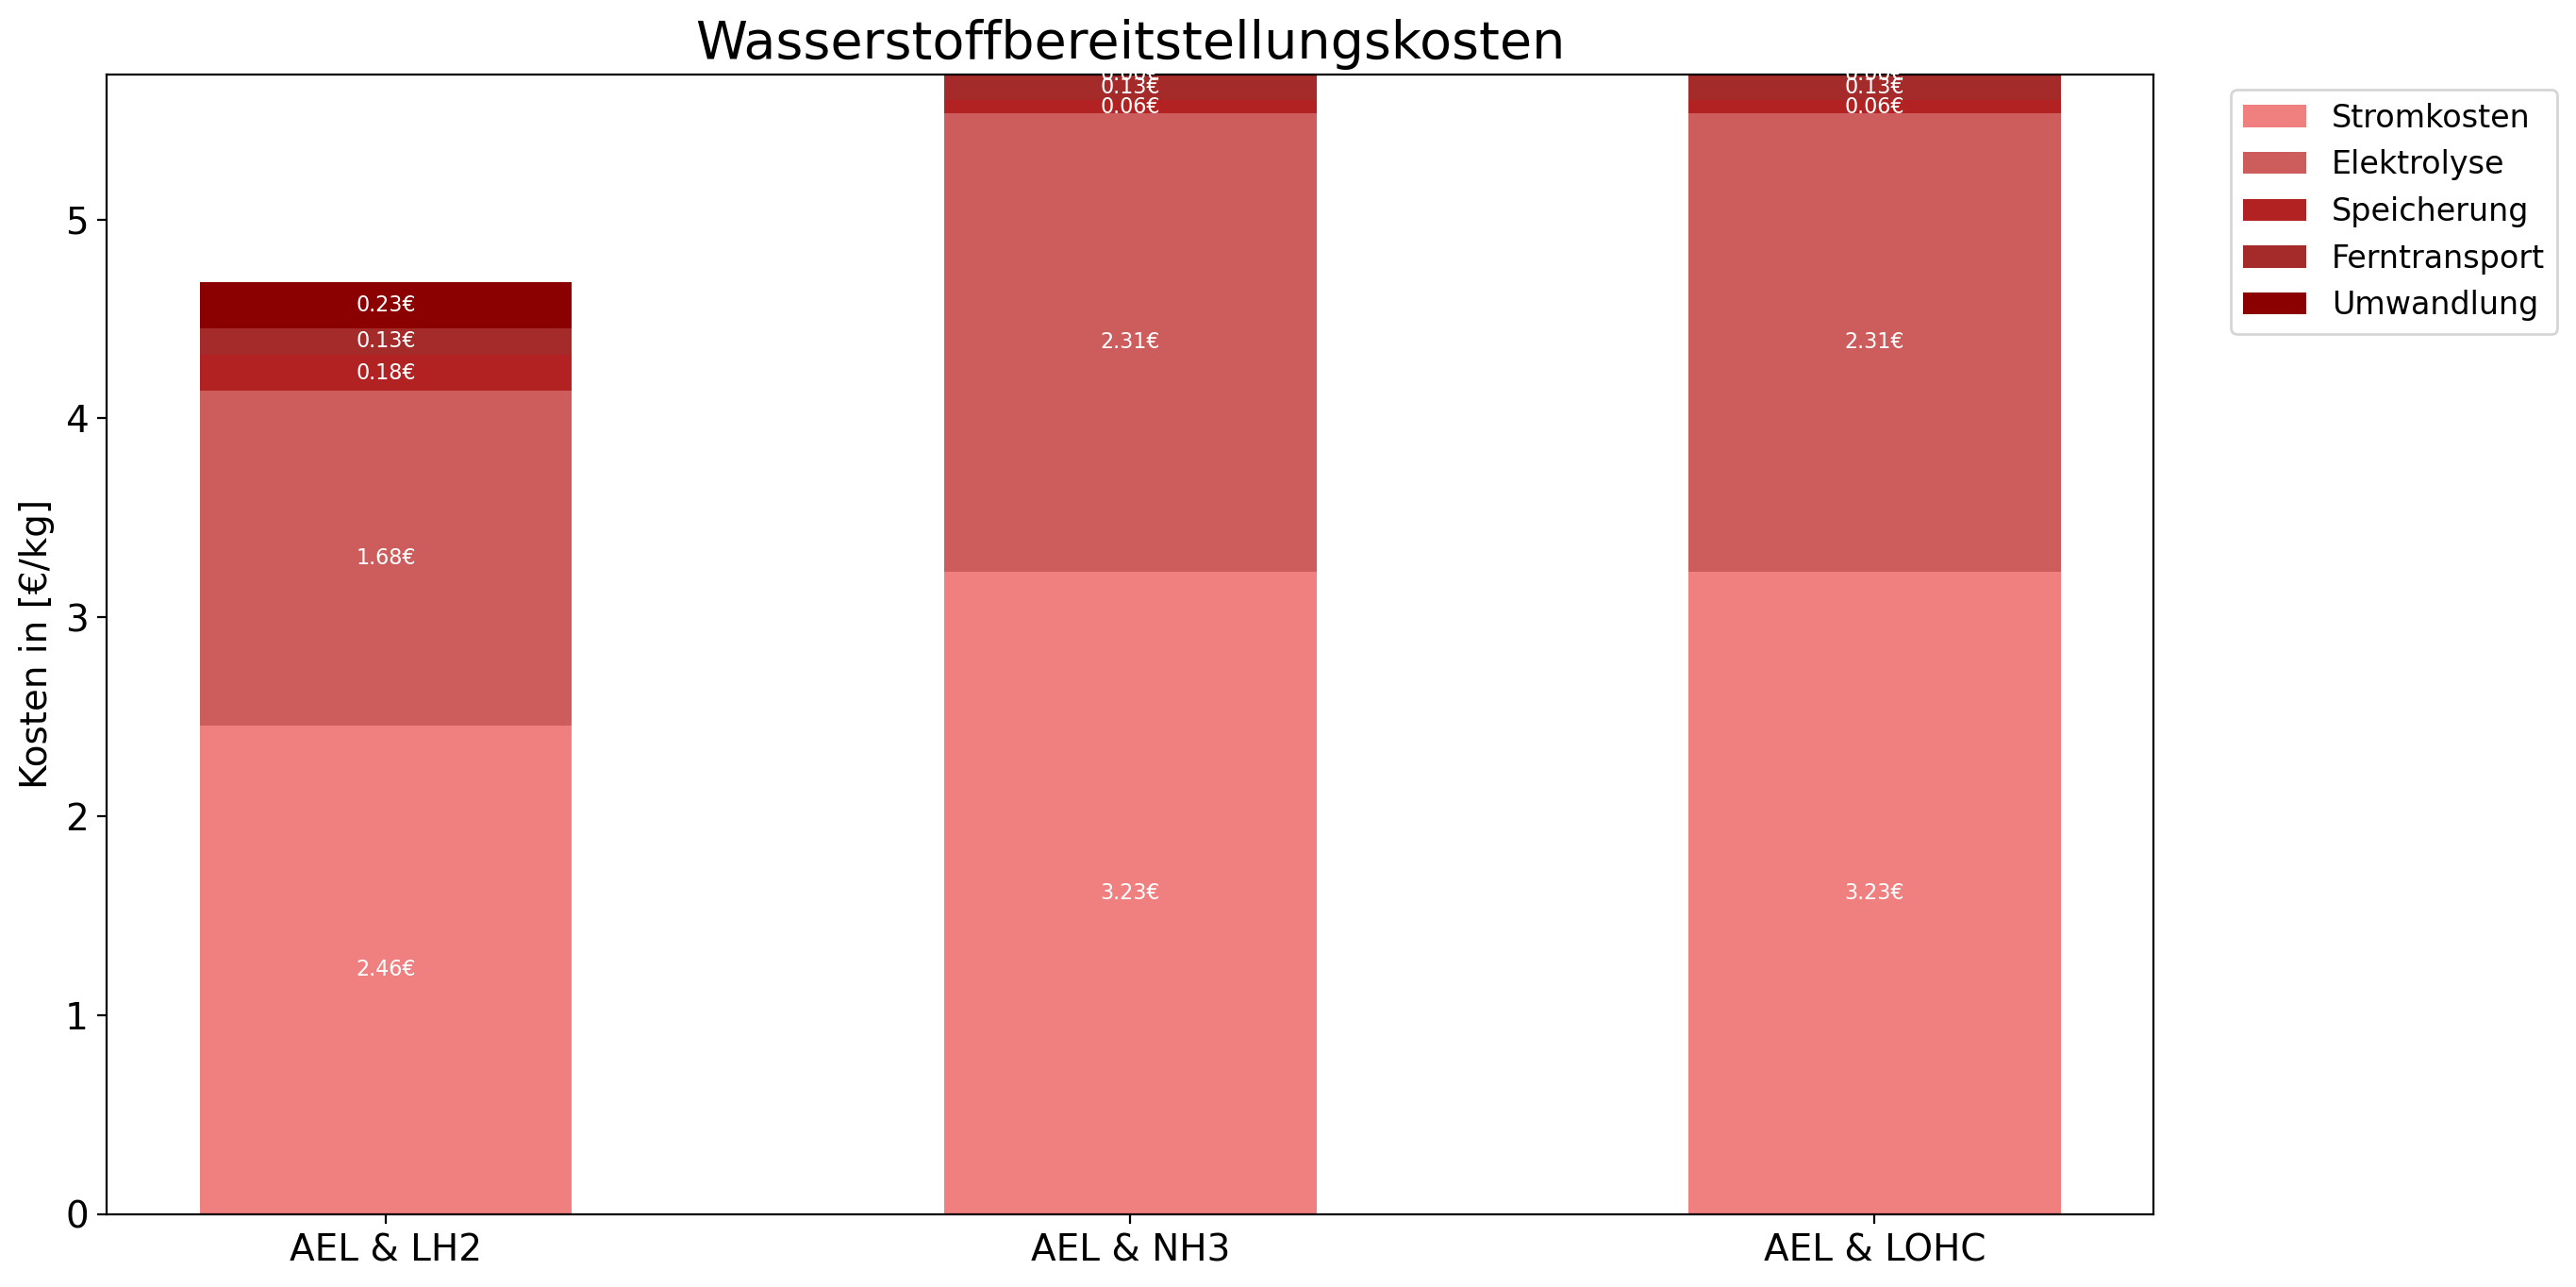

In [53]:
# Übersicht der Kilopreise

labels = ['AEL & LH2', 'AEL & NH3', 'AEL & LOHC']
Stromkosten = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Stromkosten'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Stromkosten'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Stromkosten']])

Elektrolyse = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Elektrolyse'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Elektrolyse'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Elektrolyse']])
                         
Umwandlung =  np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Umwandlung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Umwandlung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Umwandlung']])
                          
Ferntransport_1 = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Transport'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Transport'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Transport']])

                         
Speicherung = np.array([Gestehungskosten_Wasserstoff_1['Gestehungspreis [€/kg]']['Speicherung'],
                        Gestehungskosten_Wasserstoff_2['Gestehungspreis [€/kg]']['Speicherung'],
                         Gestehungskosten_Wasserstoff_3['Gestehungspreis [€/kg]']['Speicherung']])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Umwandlung',width=width,color='darkred')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellungskosten')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=8,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

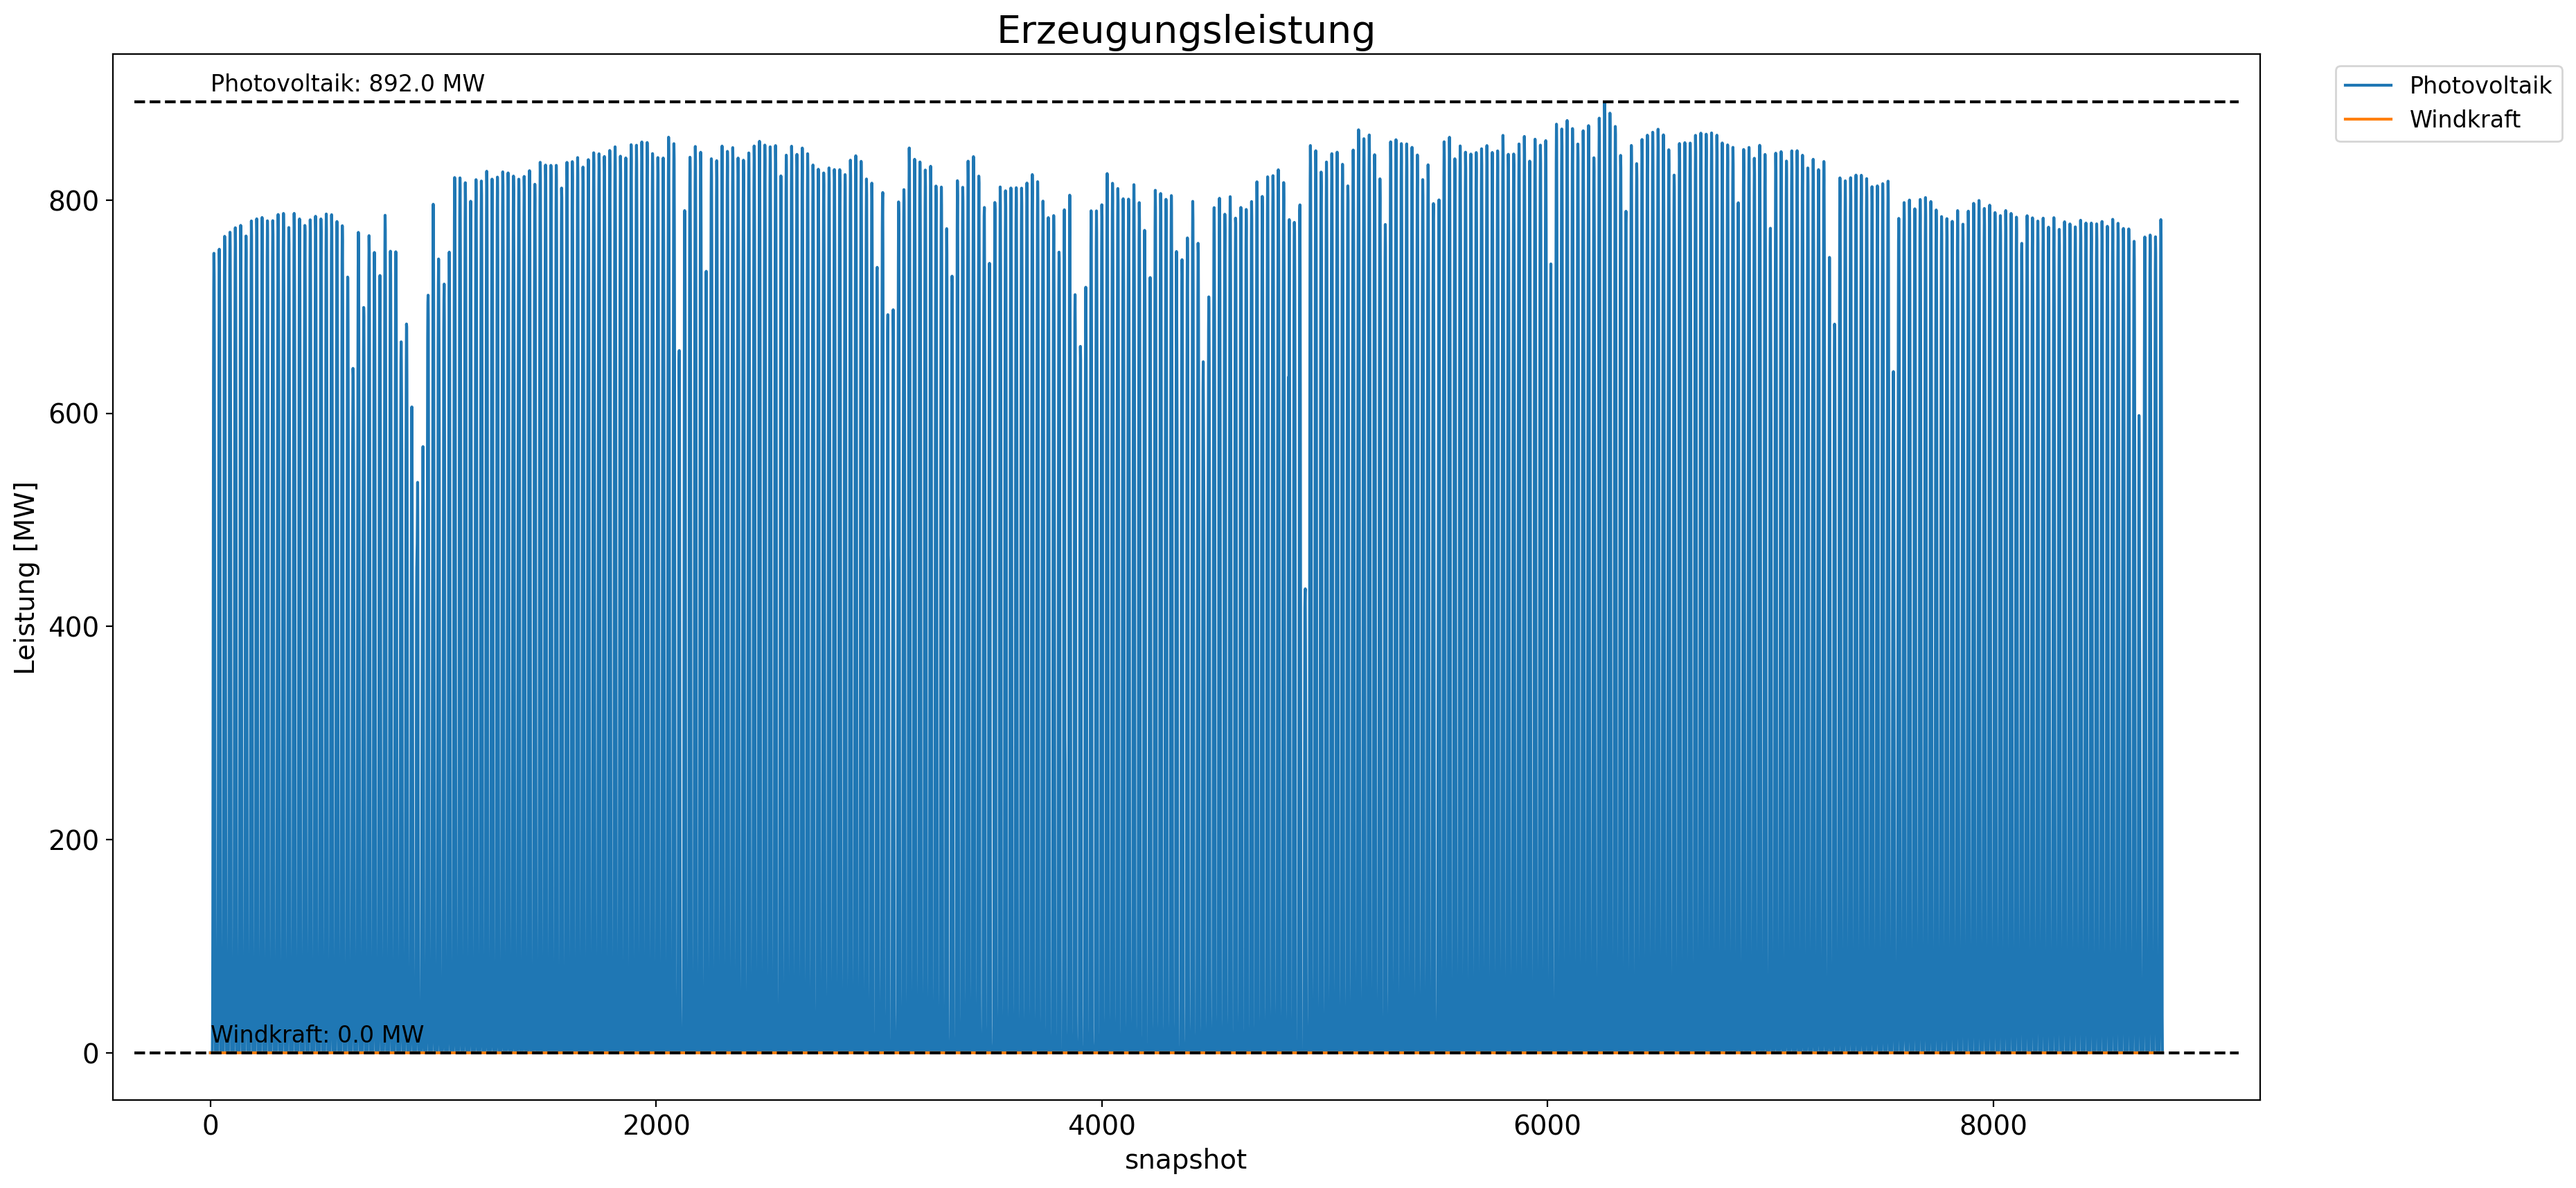

In [40]:
# Darstellung der optimierten Erzeugungsleistung

ax = network1.generators_t.p.plot()

plt.axhline(y=network1.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Photovoltaik: '+str(network1.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network1.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Windkraft: '+str(network1.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network1.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()                  

In [41]:
Dauerlinie(network1.generators_t,p,'Hi','Leistung')

AttributeError: sort_values

In [ ]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network1.links_t.p0['PEMEL'])
ax.plot(network1.links_t.p0['AEL'])

plt.axhline(y=network1.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network1.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'PEMEL: '+str(network1.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network1.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'AEL: '+str(network1.links.p_nom_opt.round(0)['AEL'])+' MW', y = network1.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Vergleich von Umwandlung und Ferntransport

In [ ]:
Betrachtungszeitraum = 5 #Tag(e)

In [ ]:
# Plot

a=200
b=a+Betrachtungszeitraum*24

ax=network1.links_t.p0.loc[a:b].plot(ylabel = 'Leistung in MW')
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

### Vergleich von Speicherung und Ferntransport

In [ ]:
# Plot_AEL&PEM_ Speicher_und_Verschiffung

a=0
b=5000
fig, ax1 = plt.subplots(sharey = True)
Verschiffung_Tonnen=network1.links_t.p0['Verschiffung LH2']/33
ax2 = ax1.twinx()
ax2.plot(Verschiffung_Tonnen.loc[a:b],
        label = 'Verschiffung LH2',color='red')
ax1.plot(network1.stores_t.e['Flüssigspeicher Chile'].loc[a:b],
        label = 'Flüssigspeicher Chile')
ax1.plot(network1.stores_t.e['Flüssigspeicher Bremerhaven'].loc[a:b],
        label = 'Flüssigspeicher Bremerhaven')
ax2.set_ylabel('Kapazität Verschiffung [t/h]')
ax1.set_ylabel('Kapazität Speicher [MWh]')


horiz_offset = 1.1
vert_offset = 0.90
fig.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

# Werkstatt

In [30]:
# Berechnung des Wasserstoffpreises in €/kg

# Wasserstoffproduktion
if electrolysis_PEMEL:
    hydrogen_production_MWh_PEMEL = -(network1.links_t.p1['PEMEL'].sum())
else:
    hydrogen_production_MWh_PEMEL = 0
    
if electrolysis_AEL:
    hydrogen_production_MWh_AEL = -(network1.links_t.p1['AEL'].sum())
else:
    hydrogen_production_MWh_AEL = 0

hydrogen_production_MWh = hydrogen_production_MWh_PEMEL + hydrogen_production_MWh_AEL
hydrogen_production_kg = hydrogen_production_MWh/(hydrogen_energy_content)*1000

# Kilopreis der Generatoren
Generatorkosten = (((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime
                    + network1.generators.marginal_cost * network1.generators_t.p.sum())/network1.generators_t.p.sum()
                   / hydrogen_energy_content).fillna(0)
     
Generatorkosten=pd.DataFrame(Generatorkosten,columns=['Preis [€/kg]'])
Generatorkosten['Generator']=Generatorkosten.index
Generatorkosten=Generatorkosten[['Preis [€/kg]']]

# Kilopreis der Links
Linkkosten = (((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime
              + network1.links.marginal_cost*(-network1.links_t.p1.sum()))
              /hydrogen_production_kg)

Linkkosten=pd.DataFrame(Linkkosten,columns=['Preis [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten[['Preis [€/kg]']]

# Kilopreis der Speicher
Speicherkosten = (((network1.stores.e_nom_opt * network1.stores.capital_cost)/network1.stores.lifetime
                   + network1.stores.marginal_cost*network1.stores_t.e.sum())/hydrogen_production_kg)

Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Preis [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten[['Preis [€/kg]']]

Kilogrammpreis = (Generatorkosten.append(Linkkosten).append(Speicherkosten))
#Kilogrammpreis

# Erstellung der Dataframes zur Darstellung in den Kategorien

Kilogrammpreis_Strom = pd.DataFrame((Kilogrammpreis.iloc[[0,1]].append(Kilogrammpreis.loc[['Stromspeicher']]).sum())).rename(index={'Preis [€/kg]': 'Stromkosten'})
Kilogrammpreis_Elektrolyse = pd.DataFrame(Kilogrammpreis.iloc[[2,3]].sum()).rename(index={'Preis [€/kg]': 'Elektrolyse'})
Kilogrammpreis_Umwandlung = pd.DataFrame(Kilogrammpreis.iloc[[4,5]].sum()).rename(index={'Preis [€/kg]': 'Umwandlung'})
Kilogrammpreis_Transport = pd.DataFrame(Kilogrammpreis.iloc[[6,7]].sum()).rename(index={'Preis [€/kg]': 'Transport'})
Kilogrammpreis_Speicherung = pd.DataFrame(Kilogrammpreis.iloc[[9,10]].sum()).rename(index={'Preis [€/kg]': 'Speicherung'})

Gestehungskosten_Wasserstoff_1 = (Kilogrammpreis_Strom
                                .append(Kilogrammpreis_Elektrolyse)
                                .append(Kilogrammpreis_Umwandlung)
                                .append(Kilogrammpreis_Transport)
                                .append(Kilogrammpreis_Speicherung)).rename(columns = {0:'Gestehungspreis [€/kg]'})
#Gestehungskosten_Wasserstoff_1

In [ ]:
Gestehungskosten_Wasserstoff

In [ ]:
# Gestehungskosten_Wasserstoff.plot.pie(subplots = True)

## Grafiken des Kilogrammpreises für alle Komponenten

In dieser Grafik spiele ich gerade ein bisschen rum, um eine Abbildung für die Präsentation morgen zu bekommen

TODO: Anstatt auf nummerierte Zeilen zuzugreifen, lieber auf die Benennung bzw inde

Ursprüngliche Grafik

In [ ]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([Linkkosten['Value [€/kg]'][0],Linkkosten['Value [€/kg]'][1]])
Elektrolyse = np.array([2,1.5])
Speicherung = np.array([0.15,0.12])
Ferntransport_1 = np.array([1,0.2])
frachtfrafrachtfra
Umwandlung = np.array([0.7,0.3])
Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(7,7))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€]')
ax.set_title('Wasserstoffbereitstellungskosten in €/kg Wasserstoff')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

## Archiv

In [ ]:
# Kilopreis der Links - ACHTUNG: veraltet und vermutlich falsch!!!
Linkkosten = ((network1.links.p_nom_opt * network1.links.capital_cost)/network1.links.lifetime+network1.links.marginal_cost*hydrogen_production_kg*(33/1000))/hydrogen_production_kg
Linkkosten=pd.DataFrame(Linkkosten,columns=['Value [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten.reset_index(drop=True)
Linkkosten=Linkkosten[['Link','Value [€/kg]']]
Linkkosten

In [ ]:
# Test

# Gespeicherte Wasserstoffmenge in kg
hydrogen_storage_kg = (network1.stores_t.e.sum()/(hydrogen_energy_content*1000)) #kg/a


# Betriebskosten pro Jahr
marginal_cost_links = network1.links.marginal_cost * network1.links_t.p0.sum() # €/a
marginal_cost_stores = network1.stores.marginal_cost * network1.stores_t.e.sum() # €/a

# Investitionskosten pro Jahr
capital_cost_links = network1.links.capital_cost * network1.links.p_nom_opt # €
capital_cost_stores = network1.stores.capital_cost * network1.stores.e_nom_opt # €

# Lebenszeit
lifetime_links = network1.links.lifetime # €
lifetime_stores = network1.stores.lifetime # €


# Kilopreis Links
hydrogen_price_links = ((((capital_cost_links/lifetime_links)+marginal_cost_links))/hydrogen_production_kg).round(2)

# Kilopreis Stores
hydrogen_price_stores = ((((capital_cost_stores/lifetime_stores)+marginal_cost_stores))/hydrogen_storage_kg).round(2)



In [ ]:
# Kilopreis der Generatoren     
electricity_price_MWh = ((network1.generators.capital_cost * network1.generators.p_nom_opt)/network1.generators.lifetime 
                         + network1.generators.marginal_cost * network1.generators_t.p.sum())/network1.generators_t.p.sum()
electricity_price_kg = electricity_price_MWh / hydrogen_energy_content
electricity_price_kg

In [ ]:
# Kaptialkosten pro kg Elektrolyse
electrolysis_capital_cost = (((links_electrolysis.T.loc['p_nom_opt'] * links_electrolysis.T.loc['capital_cost'])
                             /links_electrolysis.T.loc['lifetime'])/hydrogen_demand_kg)
electrolysis_capital_cost

In [ ]:
electrolysis_marginal_cost = (links_electrolysis.T.loc['marginal_cost'] * hydrogen_production_MWh)/hydrogen_production_kg
electrolysis_marginal_cost

In [ ]:
# Betriebskosten pro kg Elektrolyse
marginal_AEL = (-(network1.links.marginal_cost['AEL'] * network1.links_t.p0['AEL'].sum())
                /(network1.links_t.p1['AEL'].sum()/(hydrogen_energy_content/1000))) # €/kg

marginal_PEMEL = (-(network1.links.marginal_cost['PEMEL'] * network1.links_t.p0['PEMEL'].sum())
                /(network1.links_t.p1['PEMEL'].sum()/(hydrogen_energy_content/1000))) # €/kg

In [ ]:
#Kapitalkosten pro kg Elektrolyse
capital_AEL = (-((network1.links.capital_cost['AEL'] * network1.links.p_nom_opt['AEL'])
                 /network1.links.lifetime['AEL'])/(network1.links_t.p1['AEL'].sum()
                                                  /(hydrogen_energy_content/1000))) # €/kg

capital_PEMEL = (-((network1.links.capital_cost['PEMEL'] * network1.links.p_nom_opt['PEMEL'])
                 /network1.links.lifetime['PEMEL'])/(network1.links_t.p1['PEMEL'].sum()
                                                  /(hydrogen_energy_content/1000))) # €/kg